# Gaussian Factors

**COMP9418-19T3, W09 Tutorial**

- Instructor: Gustavo Batista
- School of Computer Science and Engineering, UNSW Sydney
- Notebook designed by Jeremy Gillen
- Last Update 19th August at 18:00, 2021
$$
% macros
\newcommand{\indep}{\perp \!\!\!\perp}
$$
$$
% macros
\newcommand{\b}{\boldsymbol}
$$

### Outline
* Gaussian Factor Class
    * Representation of a multidimensional gaussian distribution
    * Initialising the distribution
    * reordering the domain
    * Join
    * Marginalise
    * Evidence
* Noisy Localisation
    * Dynamic Bayesian Network definition
    * Implementation as HMM
    * Demonstration with animation

## Technical Prerequisites

We will import the following modules for later use:

In [19]:
import copy
import numpy as np
import matplotlib.pyplot as plt

The purpose of this tutorial is to introduce Bayesian Networks that are made of continuous Gaussian random variables instead of discrete random variables. The source of this content is Chapter 14.2 of *Probabilistic Graphical Models: Principles and Techniques*, by Koller & Friedman.

## Representing a Gaussian distribution

An $n$-dimensional Gaussian distribution is defined with it's mean vector $\b\mu$ and covariance matrix $\Sigma$:
$$ P(\b x) = \frac{1}{(2\pi)^{n/2} |\Sigma|^{1/2}}\exp \left(-\frac{1}{2} (\b x - \b \mu)^T\Sigma^{-1}(\b x - \b \mu)\right). $$

Note that $|\Sigma|$ is the determinant of the covariance matrix.

As we know from the theory section of the tutorial, a multidimensional gaussian distribution can also be represented with the following equation:

$$ P(\b x) = \exp \left(-\frac{1}{2} \b{x}^T K \b x + \b h^T \b x + g\right),$$

where 
* $\b x$ is an $n$-dimension vector representing the outcome of each variable
* $K = \Sigma^{-1}$ is an $n \times n$ matrix
* $\b h = \Sigma^{-1}\b \mu$ is an $n$-dimension vector
* $g = -\frac{1}{2}\b \mu^T\Sigma^{-1}\b \mu - \log\left((2\pi)^{n/2} |\Sigma|^{1/2}\right)$ is a scalar 



## Exercise

Let's create a class to represent a Gaussian Factor. The first method to complete is `__init__`, which will give us multiple ways to initialize the distribution, as described in the docstring. 

For the purposes of testing, we have implemented a method to calculate the density at any point, and plot the distribution, and print out a string representation of the object.

In [20]:
class GaussianFactor:
    def __init__(self, domain, mu=None, sigma=None, parents=None, beta=None, b_mean=None, b_var=None, K=None, h=None, g=None):
        '''
        There are three ways to initialize this object.
        1. As a multivariate gaussian
        domain:   A list or tuple of the names of each variable.
        mu:       The mean vector
        sigma:    The covariance matrix
        
        2. As a conditional distribution Y|X where Y = beta^T X + b
        domain:   List of names with the *child variable first*.
        beta:     The vector of parameters which define the scale each of the variables X_i
        b_mean:   The mean of b
        b_var:    The variance of b
        
        3. Directly with the cannonical form of the parameters
        domain:  A list or tuple of the names of each variable.
        K:       see cell above, (or Koller&Friedman textbook (section 14.2.1.1)) for definitions of these variables
        h:
        g:
        '''
        n = len(domain)
        self.domain = domain
        if mu is not None and sigma is not None:
            mu, sigma = np.array(mu).reshape((n,)), np.array(sigma).reshape((n,n))
            self.K = ... # TODO
            self.h = ... # TODO
            self.g = ... # TODO
        elif K is not None and h is not None and g is not None:
            self.K = np.array(K).reshape((n,n))
            self.h = np.array(h).reshape((n,))
            self.g = np.array(g).reshape((1,))
        elif beta is not None and b_mean is not None and b_var is not None:
            # We will complete the function below in the next exercise
            K,h,g = self._init_as_conditional(domain[0],domain[1:], beta, b_mean, b_var)
            self.K = K
            self.h = h
            self.g = g
        else:
            raise ValueError("Insufficient arguments")
            
    def density(self, x):
        '''
        x:  ndarray of shape [..., len(domain)], to specifiy the set of 
        points in the domain space for which the density should be returned.
        
        returns: ndarray of shape [...], same as input but missing final dimension.
        '''
        x = np.array(x)
        if x.shape == tuple():
            x = x.reshape(-1)
        if len(self.domain) == 1 and x.shape[-1] != 1:
            x = x.reshape((*x.shape,1))
        assert(x.shape[-1] == len(self.domain))
        output_shape = x.shape[:-1]
        xT = np.array(x).reshape((*x.shape[:-1],1,len(self.domain)))
        x = np.array(x).reshape((*x.shape[:-1],len(self.domain),1))
        hT = self.h.reshape(1,len(self.domain))
        return np.exp(-(1/2)*xT@self.K@x+hT@x+self.g).reshape(output_shape)
    
    def plot(self):
        '''
        If mean() and covariance() are well defined (and sometimes when they aren't),
        this function will plot a graph or contour diagram of the distribution.
        Limited to 1 or 2 dimensional factors.
        '''
        try:
            mu = self.mean()
        except np.linalg.LinAlgError:
            raise np.linalg.LinAlgError("Can't plot conditional distributions")
            
        if len(self.domain) == 1:
            mu = self.mean()
            sigma = np.sqrt(self.covariance())[0,0]
            x = np.linspace(mu-5, mu+5, 100)
            y = self.density(x)
            plt.plot(x,y)
            plt.xlabel(f'Domain: {self.domain[0]}')
            plt.ylabel('density')
            plt.show()
        elif len(self.domain) == 2:
            mu = self.mean()
            x1 = np.linspace(mu[0]-5,mu[0]+5,200).reshape(-1,1)
            x2 = np.linspace(mu[1]-5,mu[1]+5,200).reshape(1,-1)
            a,b = np.meshgrid(x1,x2)
            x = np.dstack([a,b])
            y = self.density(x)
            plt.contour(a,b, y)
            plt.xlabel(f'Domain: {self.domain[0]}')
            plt.ylabel(f'Domain: {self.domain[1]}')
            plt.show()
        else:
            print("Error: Need 1 or 2 dimensional gaussian for plotting")
            
    def mean(self):
        '''
        Returns the mean of this gaussian distribution, assuming it is well defined (it isn't if conditional).
        '''
        return np.linalg.inv(self.K)@self.h
    
    def covariance(self):
        '''
        Returns the covariance matrix of this gaussian distribution, assuming it is well defined (it isn't if conditional).
        '''
        return np.linalg.inv(self.K)


    def copy(self):
        '''
        Creates a full copy of the object
        '''
        return copy.deepcopy(self)
            
    def __str__(self):
        '''
        Creates a string representation of the distribution.
        Tries to print the mean and covariance.
        If distribution is conditional, the covariance matrix isn't well defined, so it resorts
        to printing the cannonical form parameters.
        '''
        try:
            return f"Factor over {tuple(self.domain)},\nμ = {self.mean()},\nΣ = \n{self.covariance()}"
        except np.linalg.LinAlgError:
            return f"Factor over {tuple(self.domain)},\nK = \n{self.K},\nh = {self.h},\ng = {self.g}"
        
        
################
# Test code
################

%matplotlib inline

# Test 1 dimensional factor
a = GaussianFactor(('A',),mu=1,sigma=0.8)
print(a)
print(f"Density at A=0.5 is {a.density([0.5])}")
a.plot()


mu = [1.5, 5]
sigma = [[0.8, 1.6],
         [1.6, 3.29]]
b = GaussianFactor(('B','A'),mu,sigma)
print(b)
print(f"Density at B=0,A=2 is {b.density([0,2])}")
b.plot()



Factor over ('A',),
K = 
Ellipsis,
h = Ellipsis,
g = Ellipsis


AttributeError: 'ellipsis' object has no attribute 'reshape'

If your solution is correct, you should see the following output:
```
Factor over ('A',),
μ = [1.],
Σ = 
[[0.8]]
Density at A=0.5 is 0.3815105565219395
<plot>

Factor over ('B', 'A'),
μ = [1.5 5. ],
Σ = 
[[0.8  1.6 ]
 [1.6  3.29]]
Density at B=0,A=2 is 0.1453540939204838
<plot>
```

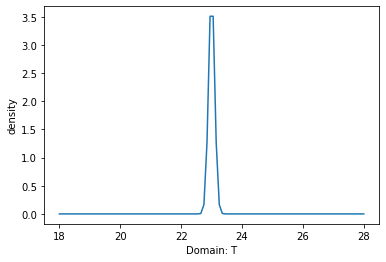

In [22]:
temp1 = GaussianFactor(('T',), [23], [0.1**2])
temp1.plot()

## Exercise

Now we want to be able to make a conditional factor. Remember that with discrete factors, we were able to do this simply by using different numbers in a probability table. With Gaussian factors, it's slightly more complex.

Lets say we want to define a variable $Y$ as a linear combination of several other gaussian variables. This means $Y = \beta_0 X_0 + \beta_1 X_1 + ... \beta_n X_n + b$, or equivalently $Y = \beta^T X + b$. Each $X_i$ is a Gaussian variable of unknown mean and variance, and $b$ is a bias random variable with mean $\mu_b$ and variance $\sigma_b^2$.

Then we can represent this conditional distribution with the following values for $K$, $h$ and $g$:

$$
\begin{align}
K_{Y|X} &= \begin{bmatrix}
\frac{1}{\sigma_b^2} & -\frac{1}{\sigma^2_b}\beta^T\\
-\frac{1}{\sigma^2_b}\beta & \frac{1}{\sigma^2_b}\beta \beta^T\\
\end{bmatrix}
\\
h_{Y|X} &= \begin{bmatrix}
\frac{1}{\sigma^2_b}\mu_b\\
-\frac{1}{\sigma^2_b}\mu_b\beta\\
\end{bmatrix}
\\
g_{Y|X} &= -\frac{1}{2}\left( \frac{\mu_b^2}{\sigma^2_b} \right)- \frac{1}{2}\log(2\pi\sigma_b^2)
\end{align}
$$

Note that $K_{Y|X}$ is a [Block Matrix](https://en.wikipedia.org/wiki/Block_matrix). The submatricies of $K_{Y|X}$ have shapes $\begin{bmatrix}
1\times1 & 1\times n\\
n\times 1 & n\times n\\
\end{bmatrix}$.


In [23]:
class GaussianFactor(GaussianFactor):
    def _init_as_conditional(self, child, parents, beta, mean, var):
        '''
        This function is only to be used by the __init__ function.
        This function initialises the factor as a conditional distribution P(Y|X),
        where Y = \beta^T X + b.
        Arguments:
        child: Name of Y
        parents: Names of each X
        beta: vector to multiply with X
        mean: mean of b
        var: variance of b
        Explanation and derivation of this function (advanced and out of scope material) is provided at the bottom of the notebook.
        '''
        n = len(beta)
        beta = np.array(beta).reshape((n,1)) # make sure beta is a column vector
        K = np.zeros((n+1,n+1))
        
        # top left section of K
        K[0,0] = ... # TODO
        # top right section of K
        K[0:1,1:] = ... # TODO
        # bottom left section of K
        K[1:,0:1] = ... # TODO
        # bottom right section of K
        K[1:,1:] = ... # TODO
        
        h = np.zeros((n+1,1))
        # top section of h
        h[0,:] = ... # TODO
        # bottom section of h
        h[1:,:] = ... # TODO
        
        # reshape h to be row vector (for consistency with previous format)
        h = h.reshape(-1)
        
        g = -(1/2)*(mean**2/var) - (1/2)*np.log(2*np.pi*var)
        
        return K,h,g
################
# Test code
################

b = GaussianFactor(('B','A'),beta=[2],b_mean=1,b_var=0.3**2)
print(b.K)
print(b.h)
print(b.g)
print()

e = GaussianFactor(('B','A','D'),beta=[5,2],b_mean=-1,b_var=0.5**2)
print(e)


TypeError: float() argument must be a string or a number, not 'ellipsis'

If your solution is correct, you should see the following output:
```
[[ 11.11111111 -22.22222222]
 [-22.22222222  44.44444444]]
[ 11.11111111 -22.22222222]
-5.2705212844342935

Factor over ('B', 'A', 'D'),
K = 
[[  4. -20.  -8.]
 [-20. 100.  40.]
 [ -8.  40.  16.]],
h = [-4. 20.  8.],
g = -2.2257913526447273
```

In tutorial 2, before we multiplied two arrays, we had to reorder the domain of a factor, and extend the domain to include new variables. We will make a separate function for this purpose, since we need to be able to reorder the domain for the join, marginalize and evidence functions.

Now we need a way to do this for Gaussian factors. Fortunately, it's not too complicated.
We will implement a method for you called `_extend` which receives as an argument the new domain that it needs to have, and shuffles up $K$, $h$, and $g$ to match the order of the new domain. If the domain contains new variables not in the current domain, we can simply put zeros in the corresponding location of $K$ and $h$.

In [25]:
class GaussianFactor(GaussianFactor):
    def _extend(self, new_domain):
        '''
        This function is for adding variables to the domain, or reordering the variables in the domain
        Note that self.domain must be contain a subset of the variables in new_domain
        '''
        n = len(new_domain)
        
        # add zeros to K and h corresponding to the new variables
        new_K = np.zeros((len(new_domain),len(new_domain)))
        new_K[:len(self.domain), :len(self.domain)] = self.K
        new_h = np.zeros(len(new_domain))
        new_h[:len(self.domain)] = self.h
        new_g = self.g
        old_order = list(self.domain) + list(set(new_domain)-set(self.domain))
        # shuffle rows and columns of K according to new order
        new_order = []
        for v in new_domain:
            new_order.append(old_order.index(v))
        new_K = new_K[new_order,:]
        new_K = new_K[:,new_order]

        # shuffle h according to new order
        new_h = new_h[new_order]
        
        return self.__class__(new_domain, K=new_K, h=new_h, g=new_g)
        

################
# Demonstration code
################


e = GaussianFactor(('B','A','D'),beta=[5,2],b_mean=-1,b_var=0.5**2)
print(e)
print(e._extend(('D', 'A', 'B')))

Factor over ('B', 'A', 'D'),
K = 
[[  4. -20.  -8.]
 [-20. 100.  40.]
 [ -8.  40.  16.]],
h = [-4. 20.  8.],
g = -2.2257913526447273
Factor over ('D', 'A', 'B'),
K = 
[[ 16.  40.  -8.]
 [ 40. 100. -20.]
 [ -8. -20.   4.]],
h = [ 8. 20. -4.],
g = [-2.22579135]


## Exercise
Finally, we are ready to implement `join`. This was derived in the theory section of the tutorial.

In [26]:
class GaussianFactor(GaussianFactor):
    def join(self, other):
        '''
        This function multiplies two factors.
        '''
        new_domain = list(self.domain) + list(set(other.domain)-set(self.domain))
        
        # extend the domain of self and other
        new_self = self._extend(new_domain)
        new_other = other._extend(new_domain)
        
        # Calculate the new values of K, h and g
        K = ... # TODO
        h = ... # TODO
        g = ... # TODO
        
        # return new joined factor
        return self.__class__(new_domain,K=K,h=h,g=g)
    
    def __mul__(self, other):
        '''
        Override the * operator, so that it can be used to join factors
        '''
        return self.join(other)

################
# Test code
################

a = GaussianFactor(('A',),mu=5.,sigma=0.8**2)
b = GaussianFactor(('B','A'),beta=[2],b_mean=3,b_var=0.3**2)
c = a.join(b)
print(a)
print(c)
c.plot()

d = GaussianFactor(('A',),mu=0, sigma=0.5**2)
e = d*a
print(e)
e.plot()


ValueError: cannot reshape array of size 1 into shape (2,2)

Output should be:
```
Factor over ('A',),
μ = [5.],
Σ = 
[[0.64]]
Factor over ('A', 'B'),
μ = [ 5. 13.],
Σ = 
[[0.64 1.28]
 [1.28 2.65]]
<plot>

Factor over ('A',),
μ = [1.40449438],
Σ = 
[[0.17977528]]
<plot>
```

## Exercise
Now we will implement the marginalize function. This involves splitting up the domain into the set of variables to keep (which we will call $X$), and the variable to integrate out (which we will call $Y$). Now the equations to update $K$, $h$ and $g$ are:
$$
\begin{align}
K' &= K_{xx} - K_{xy}K_{yy}^{-1}K_{yx} \\
h' &= h_x - K_{xy}K_{yy}^{-1}h_y \\
g' &= g + \frac{1}{2}\left(\log |2\pi K_{yy}^{-1}| + h_y^T K_{yy}^{-1}h_y\right)
\end{align}
$$

In [28]:
class GaussianFactor(GaussianFactor):
    def marginalize(self, var):
        '''
        This function integrates out one variable from the domain
        '''
        n = len(self.domain)
        new_domain = list(self.domain)
        new_domain.remove(var)
        f = self._extend(new_domain+[var]) #reorder the variables to put var last
        
        # Select submatricies from K and h
        K_yy_inv = np.linalg.inv(f.K[-1:,-1:])
        K_xx = f.K[:-1,:-1]
        K_xy = f.K[:-1,-1:]
        K_yx = f.K[-1:,:-1]
        h_x = f.h[:-1]
        h_y = f.h[-1:]
        
        # Use the submatricies above to calculate the updated K, h and g
        new_K = ... # TODO
        new_h = ... # TODO
        new_g = ... # TODO
        
        return self.__class__(new_domain, K=new_K, h=new_h,g=new_g)

################
# Test code
################

a = GaussianFactor(('A','B'),mu=[5., 13.],sigma=[[0.64, 1.28],[1.28,2.65]])
print(a)
b = a.marginalize('A')
print(b)

d = GaussianFactor(('D',),mu=1,sigma=0.2)
e = GaussianFactor(('B','A','D'),beta=[5,2],b_mean=-1,b_var=0.5**2)
f = e*a*d
print(f)
f = f.marginalize('A').marginalize('D')
print(f)


Factor over ('A', 'B'),
μ = [ 5. 13.],
Σ = 
[[0.64 1.28]
 [1.28 2.65]]


TypeError: No loop matching the specified signature and casting was found for ufunc inv

Output should be:
```
Factor over ('A', 'B'),
μ = [ 5. 13.],
Σ = 
[[0.64 1.28]
 [1.28 2.65]]
Factor over ('B',),
μ = [13.],
Σ = 
[[2.65]]
Factor over ('B', 'A', 'D'),
μ = [5.93478261 1.3826087  0.24637681],
Σ = 
[[ 0.61195652  0.23652174 -0.2173913 ]
 [ 0.23652174  0.10573913 -0.11130435]
 [-0.2173913  -0.11130435  0.17681159]]
Factor over ('B',),
μ = [5.93478261],
Σ = 
[[0.61195652]]
```

## Exercise

Time for the evidence method:
Similar to above, we need to split the domain into parts. $X$ will represent variables we are keeping, and $Y$ represent the variables we are setting to a specific value. The specific values are specified by a vector $\b y$.
Then the equations to update $K$, $h$ and $g$ are:
$$
\begin{align}
K' &= K_{xx} \\
\b h' &= \b h_{x} - K_{xy} \b y \\
g' &= g + h_y^T \b y - \frac{1}{2} \b y^T K_{yy} \b y
\end{align}
$$

Factor over ('A',),
μ = [5.],
Σ = 
[[0.64]]
Factor over ('A', 'B'),
μ = [ 5. 13.],
Σ = 
[[0.64 1.28]
 [1.28 2.65]]


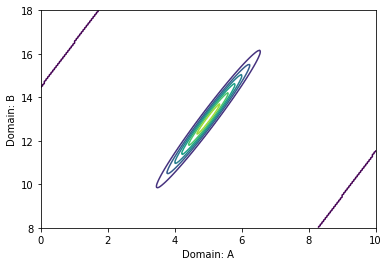

TypeError: No loop matching the specified signature and casting was found for ufunc inv

In [30]:
class GaussianFactor(GaussianFactor):
    def evidence(self, **kwargs):
        '''
        Sets evidence which results in removal of the evidence variables
        This function must be used to set evidence on all factors before any are joined,
        because it removes the evidence variables from the factor
        
        Usage: fac.evidence(A=4.6,B=-0.3)
        This returns a factor which has set the variable 'A' to '.6 and 'B' to -0.3.
        '''
        evidence_dict = kwargs
        
        if(len(evidence_dict) == 0):
            return self
        
        # work out new domain vars and evidence vars
        new_domain = list(self.domain)
        evidence_vars = []
        evidence_values = []
        for var,value in evidence_dict.items():
            new_domain.remove(var)
            evidence_vars.append(var)
            evidence_values.append(value)
            
        # rearrange the domain to put evidence vars last
        f = self._extend(new_domain+evidence_vars)
        
        # Split up K and h into sections
        n = len(evidence_vars)
        m = len(new_domain)
        K_xx = f.K[:m,:m]
        K_xy = f.K[:m,-n:]
        K_yy = f.K[-n:,-n:]
        h_x = f.h[:m]
        h_y = f.h[-n:]
        # put evidence variables into a vector called y
        y = np.array(evidence_values)
        
        # update variables
        new_K = ... # TODO
        new_h = ... # TODO
        new_g = ... # TODO
        return self.__class__(new_domain, K=new_K, h=new_h,g=new_g)
    
################
# Test code
################

a = GaussianFactor(('A',),mu=5.,sigma=0.8**2)
print(a)
b = GaussianFactor(('B','A'),beta=[2],b_mean=3,b_var=0.3**2)
c = a.join(b)
print(c)
c.plot()
print(c.evidence(A=3))


Solution should match:
```
Factor over ('A',),
μ = [5.],
Σ = 
[[0.64]]
Factor over ('A', 'B'),
μ = [ 5. 13.],
Σ = 
[[0.64 1.28]
 [1.28 2.65]]

Factor over ('B',),
μ = [9.],
Σ = 
[[0.09]]
```

For completeness, we will add a method for sampling from the factor.

Factor over ('A', 'B'),
μ = [1. 3.],
Σ = 
[[0.8  1.6 ]
 [1.6  3.29]]


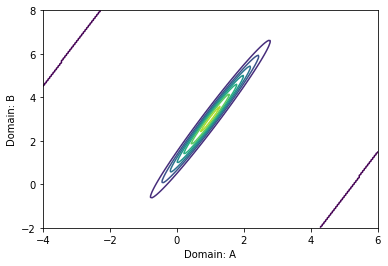

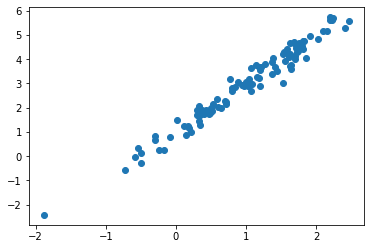

In [32]:
class GaussianFactor(GaussianFactor):
    def sample(self, **kwargs):
        '''
        Draw a sample from this distribution, given evidence.
        output: dict containing a map from variable names to values
        '''
        f = self.evidence(**kwargs)
        sample = np.random.multivariate_normal(f.mean(), f.covariance())
        sample_dict = dict((var, sample[i]) for i,var in enumerate(f.domain))
        return sample_dict
    
    def normalize(self):
        '''
        Normalize the factor (will only work if covariance is well defined)
        '''
        n = len(self.domain)
        self.g = -0.5*self.mean().T@self.h - np.log((2*np.pi)**(n/2)*np.linalg.det(self.covariance())**(1/2))
        return self


#################
# Demonstration
#################

# Compare multivariate sampling and plotting, after 
a = GaussianFactor(('A',),mu=1,sigma=0.8)
b = GaussianFactor(('B','A'),beta=[2],b_mean=1,b_var=0.3**2)
c = a.join(b)
print(c)
c.plot()
samples = [c.sample() for i in range(100)]
x = [s['A'] for s in samples]
y = [s['B'] for s in samples]
plt.plot(x,y,'o')
plt.show()

## Localisation tasks

To demonstrate the power of Gaussian Factors, we will construct a [Dynamic Bayesian Network](https://en.wikipedia.org/wiki/Dynamic_Bayesian_network) (which is just a HMM with several state and emmission variables). 

The task we want to solve is a localisation task using noisy sensors. This type of problem is very common. For example, imagine a GPS and map system in a car. The car needs to work out its location and speed as precisely as possible. It may only have two noisy sources of information, GPS signals and the accelerometer, and it needs to combine this information while taking into account the uncertainty of each source of information. Gaussian DBNs are often a good solution to problems like this. 

In our demonstration, we will imagine a spacecraft floating in 2-d space. It has 4 thrusters, pointing up, down, left and right, which it can fire to accelerate in those directions. It has access to an accelerometer in the x axis and y axis, and every now and then it receives a "GPS" signal that allows it to approximately estimate its position.

To solve this problem we will build the following model, where each variable is Gaussian, and all conditional distributions are linear combinations:



![](./img/DBN_diagram.png)


We can approximate velocity at timestep $t$ as:
$$v_{t} \approx v_{t-1} + a_{t-1},$$

and position as:
$$x_{t} \approx x_{t-1} + v_{t-1}.$$

The observation of position will be the current position plus some noise :
$$ Observation\_x_t = x_{t} + \varepsilon,$$ 
where $\varepsilon$ is some normally distributed noise variable whose variance corresponds to whatever the accuracy of the location measurement is.

Since the spacecraft knows what direction it is accelerating, it can just set the acceleration variable to the correct value. Because the thrusters might not always produce acceleration in exactly the same direction, we can simply set the acceleration factor at each timestep to a gaussian distribution over possible accelerations.

In [33]:
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

## Setting up Model Factors

In [34]:
# Transition factors
x_transition = GaussianFactor(('x_new', 'x','dx'), beta=[1,1],b_mean=0,b_var=0.001**2)
y_transition = GaussianFactor(('y_new', 'y','dy'), beta=[1,1],b_mean=0,b_var=0.001**2)
dx_transition = GaussianFactor(('dx_new', 'dx','d2x'), beta=[1,1],b_mean=0,b_var=.001**2)
dy_transition = GaussianFactor(('dy_new', 'dy','d2y'), beta=[1,1],b_mean=0,b_var=.001**2)
transition = x_transition*dx_transition*y_transition*dy_transition

# Emission factors
x_emission = GaussianFactor(('x_observation', 'x'), beta=[1],b_mean=0,b_var=3**2)
y_emission = GaussianFactor(('y_observation', 'y'), beta=[1],b_mean=0,b_var=3**2)
emission = x_emission*y_emission


# Setting up the possible acceleration factors
accel_x_prior_still = GaussianFactor(['d2x'],mu=[0],sigma=[[0.001**2]])
accel_y_prior_still = GaussianFactor(['d2y'],mu=[0],sigma=[[0.001**2]])
accel_x_prior_left = GaussianFactor(['d2x'],mu=[-0.5],sigma=[[0.1**2]])
accel_x_prior_right = GaussianFactor(['d2x'],mu=[0.5],sigma=[[0.1**2]])
accel_y_prior_up = GaussianFactor(['d2y'],mu=[0.5],sigma=[[0.1**2]])
accel_y_prior_down = GaussianFactor(['d2y'],mu=[-0.5],sigma=[[0.1**2]])

# Combining acceleration factors to make them 2d
accel_up = accel_x_prior_still*accel_y_prior_up
accel_down = accel_x_prior_still*accel_y_prior_down
accel_left = accel_y_prior_still*accel_x_prior_left
accel_right = accel_y_prior_still*accel_x_prior_right
no_accel = accel_x_prior_still*accel_y_prior_still

# Set up an initial factor over position and velocity.
pos_vel_prior = GaussianFactor(('x','y','dx','dy'),mu=[1,2,0,0], sigma=0.01*np.identity(4))

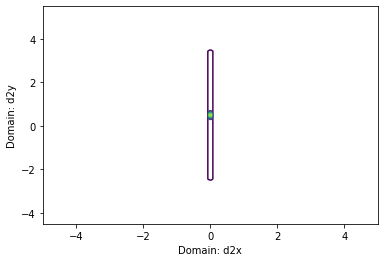

In [35]:
# Lets see what the distribution over accelerations is 
# when firing a thruster to move up.
accel_up.plot()

### Set up inference
Lets set up a class for doing transition and emission steps of inference. This is very similar to setting up a HMM.

In [36]:
class LocalisationGaussianDBN:
    def __init__(self,prior_factor,transition_factor,emission_factor,var_map):
        self.current_state = prior_factor
        self.transition_fac = transition_factor
        self.emission_fac = emission_factor
        self.original_name = var_map
        
    def transition(self,current_acceleration):
        '''
        This method does one transition step
        Arguments:
        current_acceleration - A distribution representing our knowledge about what the acceleration is.
        '''
        joint = self.current_state*current_acceleration*self.transition_fac
        # joint now has domain (x,y,dx,dy,d2x,d2y,x_new,y_new,dx_new,dy_new)
        for var in ['x','y','dx','dy','d2x','d2y']:
            joint = joint.marginalize(var)
        # rename variables back to original names
        joint.domain = tuple(self.original_name[name] for name in joint.domain)
        self.current_state = joint.normalize()

    def emission(self, evidence_dict):
        '''
        The emission step is necessary whenever the position is observed.
        evidence_dict - A dictionary of observations. E.g. {"x_observation": 3.8, "y_observation": -42.0}
        '''
        joint_with_emission_vars = self.current_state*self.emission_fac
        updated_joint = joint_with_emission_vars.evidence(**evidence_dict)
        # marginalise out any variables for which there was no evidence
        for var in updated_joint.domain:
            if var not in self.current_state.domain:
                updated_joint = updated_joint.marginalize(var)
        self.current_state = updated_joint.normalize()

        
var_map = {'x_new':'x',
           'y_new':'y',
           'dx_new':'dx',
           'dy_new':'dy',
           'd2x_new':'d2x',
           'd2y_new':'d2y',
           }
model = LocalisationGaussianDBN(pos_vel_prior,transition,emission,var_map)

### Set up animation and test

The following cell sets up an animation to demonstrate how the HMM's estimate of its current location moves as it receives information. 

The green dot shows the true location of the spacecraft, and the contour plot shows the estimate of its current location. A green dot appears when it recieves a GPS location estimate.

The array `recorded` contains a list of accelerations that the spacecraft will do. You can edit that list and rerun the animation.

Note that the view will shift whenever the red dot passes outside the current view.

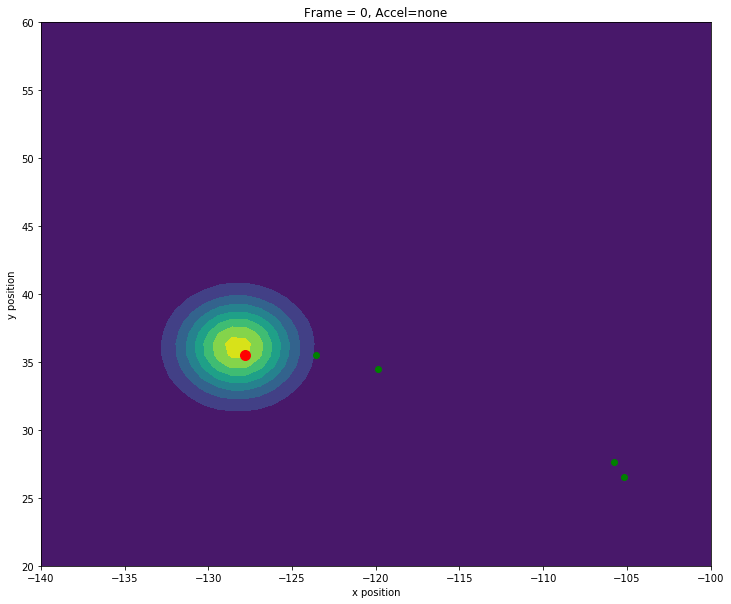

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import rc

# Reinitialize model
model = LocalisationGaussianDBN(pos_vel_prior,transition,emission,var_map)

# data generator (simulator of the real world)
def timestep(state, accel_factor):
    x,y,dx,dy = state

    observed_x = x + np.random.normal(0,1)
    observed_y = y + np.random.normal(0,1)
    observation_dict = {'x_observation':observed_x,
                        'y_observation':observed_y}
    
    accel_sample = accel_factor.sample()
    d2x = accel_sample['d2x']
    d2y = accel_sample['d2y']
    x += dx
    y += dy
    dx += d2x
    dy += d2y  
    
    return [x,y,dx,dy], observation_dict


# create a figure and axes
fig = plt.figure(figsize=(12,10))
ax1 = plt.subplot(1,1,1)   

# create objects that will change in the animation. These are
# initially empty, and will be given new values for each frame
# in the animation.
txt_title = ax1.set_title('')
pt1, = ax1.plot([], [], 'r.', ms=20)
con = ax1.contourf([1,1],[1,1], [[1,1],[2,2]])


# Set up variables to store the current state of the system    
done = False       
acceleration_dir = 'none'
acceleration = no_accel
current_loc_vel = [1,0,0,0]


recorded = ['none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'left', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'right', 'none', 'right', 'none', 'up', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'down', 'none', 'none', 'left', 'none', 'none', 'left', 'none', 'left', 'down', 'none', 'down', 'down', 'down', 'none', 'none', 'none', 'up', 'none', 'up', 'up', 'up', 'up', 'right', 'none', 'none', 'right', 'right', 'right', 'right', 'none', 'none', 'none', 'left', 'none', 'left', 'left', 'left', 'left', 'left', 'left', 'none', 'right', 'none', 'right', 'none', 'right', 'right', 'none', 'down', 'none', 'down', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'left', 'none', 'left', 'left', 'none', 'down', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'right', 'right', 'right', 'right', 'right', 'right', 'none', 'left', 'none', 'left', 'none', 'left', 'none', 'left', 'none', 'none', 'left', 'none', 'none', 'up', 'up', 'none', 'up', 'none', 'right', 'none', 'none', 'none', 'none', 'down', 'none', 'down', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none']

# animation function. This is called sequentially
def drawframe(n):
    global current_loc_vel, xy_factor, acceleration
    # Simulate time passing for one timestep
    current_loc_vel, observation = timestep(current_loc_vel, acceleration)

    # update the model with a noisy observations
    if np.random.random() < .1:
        model.emission(observation)
        ax1.plot(observation['x_observation'], observation['y_observation'],'go')

    # transition the model to the next timestep
    model.transition(acceleration)
    
    # get model's belief about current location
    xy_factor = model.current_state.copy()
    for var in ['dx','dy']:
        xy_factor = xy_factor.marginalize(var)
        
    #ax1.plot(current_loc_vel[0], current_loc_vel[1], 'ro')
    pt1.set_data(current_loc_vel[0], current_loc_vel[1])
    
    # make graph work even when you leave area
    x_offset = round(current_loc_vel[0]/40,0)*40
    y_offset = round(current_loc_vel[1]/40,0)*40

    domain_x = np.linspace(-20+x_offset,20+x_offset,50).reshape(-1,1)
    domain_y = np.linspace(-20+y_offset,20+y_offset,50).reshape(1,-1)
    a,b = np.meshgrid(domain_x,domain_y)
    
    # make sure to plot graph correctly depending on domain of xy_factor
    if xy_factor.domain == ['x','y']:
        domain = np.dstack([a,b])
    elif xy_factor.domain == ['y','x']:
        domain = np.dstack([b,a])
    density = xy_factor.density(domain)
    ax1.contourf(a,b,density)
    
    txt_title.set_text('Frame = {}, Accel={}'.format(n,recorded[n]))
    
    # get model's belief about current location
    xy_factor = model.current_state.copy()
    for var in ['dx','dy']:
        xy_factor = xy_factor.marginalize(var)
    
    # make graph work even when you leave area
    x_offset = round(current_loc_vel[0]/40,0)*40
    y_offset = round(current_loc_vel[1]/40,0)*40
    
    ax1.set_xlabel('x position')
    ax1.set_ylabel('y position')
    ax1.set_xlim([-20+x_offset,20+x_offset])
    ax1.set_ylim([-20+y_offset,20+y_offset])
    
    acceleration_dir = recorded[n]
    # get current acceleration, as specified by user input, and get corresponding prior over acceleration variables.
    if acceleration_dir == 'none':
        acceleration = no_accel
    elif acceleration_dir == 'up':
        acceleration = accel_up
    elif acceleration_dir == 'down':
        acceleration = accel_down
    elif acceleration_dir == 'left':
        acceleration = accel_left
    elif acceleration_dir == 'right':
        acceleration = accel_right
    acceleration_dir = 'none'
    
    return con.collections

anim = animation.FuncAnimation(fig, drawframe, frames=170, interval=200, blit=True)


# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')
anim

### Alternative demonstration (if running locally)

If you are running this notebook on your computer, instead of on Colab, then the next cell should make an interactive version of plot. In this version, you can use the arrow keys to accelerate the dot in different directions.

In [38]:
model = LocalisationGaussianDBN(pos_vel_prior,transition,emission,var_map)

# data generator (simulator of the real world)
def timestep(state, accel_factor):
    x,y,dx,dy = state

    observed_x = x + np.random.normal(0,1)
    observed_y = y + np.random.normal(0,1)
    observation_dict = {'x_observation':observed_x,
                        'y_observation':observed_y}
    
    accel_sample = accel_factor.sample()
    d2x = accel_sample['d2x']
    d2y = accel_sample['d2y']
    x += dx
    y += dy
    dx += d2x
    dy += d2y  
    
    return [x,y,dx,dy], observation_dict
        

# Set up variables to store the current state of the system    
done = False       
acceleration_dir = 'none'
acceleration = no_accel
current_loc_vel = [1,0,0,0]

# Set up plotting and user input processing
%matplotlib
def on_press(event):
    global acceleration_dir
    if event.key in ['up','down','left','right']:
        acceleration_dir = event.key
    elif event.key == 'q':
        done = True

fig, ax = plt.subplots()
fig.canvas.mpl_connect('key_press_event', on_press)
plt.show()

recorded = []

# Main loop which displays the HMM inference in real time.
while not done:
    # Simulate time passing for one timestep
    current_loc_vel, observation = timestep(current_loc_vel, acceleration)

    # update the model with a noisy observations
    if np.random.random() < .1:
        model.emission(observation)
        ax.plot(observation['x_observation'], observation['y_observation'],'yo')

    # transition the model to the next timestep
    model.transition(acceleration)
    
    # clear plot
    plt.cla()
    # plot current location as a red dot
    ax.plot(current_loc_vel[0], current_loc_vel[1], 'ro')
    
    # get model's belief about current location
    xy_factor = model.current_state.copy()
    for var in ['dx','dy']:
        xy_factor = xy_factor.marginalize(var)
    
    # make graph work even when you leave area
    x_offset = round(current_loc_vel[0]/20,0)*20
    y_offset = round(current_loc_vel[1]/20,0)*20
    
    # draw a contour diagram of model's current belief
    domain_x = np.linspace(-10+x_offset,10+x_offset,50).reshape(-1,1)
    domain_y = np.linspace(-10+y_offset,10+y_offset,50).reshape(1,-1)
    a,b = np.meshgrid(domain_x,domain_y)
    domain = np.dstack([b,a])
    density = xy_factor.density(domain)
    ax.contour(a,b, density)
    ax.set_xlabel('x position')
    ax.set_ylabel('y position')
    ax.set_title('Use arrow keys to accelerate; q to quit')
    ax.set_xlim([-10+x_offset,10+x_offset])
    ax.set_ylim([-10+y_offset,10+y_offset])
    
    # draw plot, then wait for user input for 0.1 seconds
    fig.canvas.draw()
    try:
        plt.pause(0.1)
    except:
        break
    recorded.append(acceleration_dir)    
    # get current acceleration, as specified by user input, and get corresponding prior over acceleration variables.
    if acceleration_dir == 'none':
        acceleration = no_accel
    elif acceleration_dir == 'up':
        acceleration = accel_up
    elif acceleration_dir == 'down':
        acceleration = accel_down
    elif acceleration_dir == 'left':
        acceleration = accel_left
    elif acceleration_dir == 'right':
        acceleration = accel_right
    acceleration_dir = 'none'
    

plt.close(fig)

Using matplotlib backend: TkAgg
